In [1]:
'''%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models'''

In [2]:
'''data_dir = '../input/ntechlab2/internship_data'
def load_split_train_test(datadir, valid_size = .1):
    train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                           transforms.RandomCrop([196, 196]),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                          ])
    test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                         ])
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=128)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=128)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)'''

['female', 'male']


In [3]:
'''device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnext50_32x4d(pretrained=True)'''

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth


In [4]:
'''for param in model.parameters():
    param.requires_grad = True
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.Sigmoid(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
model.to(device);'''

In [5]:
'''epochs = 10
steps = 0
running_loss = 0
print_every = 50
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()                
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')'''

Epoch 1/10.. Train loss: 0.289.. Test loss: 0.124.. Test accuracy: 0.954
Epoch 1/10.. Train loss: 0.107.. Test loss: 0.086.. Test accuracy: 0.969
Epoch 1/10.. Train loss: 0.098.. Test loss: 0.072.. Test accuracy: 0.973
Epoch 1/10.. Train loss: 0.077.. Test loss: 0.074.. Test accuracy: 0.972
Epoch 1/10.. Train loss: 0.072.. Test loss: 0.063.. Test accuracy: 0.977
Epoch 1/10.. Train loss: 0.070.. Test loss: 0.058.. Test accuracy: 0.979
Epoch 1/10.. Train loss: 0.065.. Test loss: 0.061.. Test accuracy: 0.977
Epoch 1/10.. Train loss: 0.063.. Test loss: 0.056.. Test accuracy: 0.979
Epoch 1/10.. Train loss: 0.072.. Test loss: 0.057.. Test accuracy: 0.979
Epoch 1/10.. Train loss: 0.063.. Test loss: 0.058.. Test accuracy: 0.978
Epoch 1/10.. Train loss: 0.062.. Test loss: 0.051.. Test accuracy: 0.981
Epoch 1/10.. Train loss: 0.054.. Test loss: 0.051.. Test accuracy: 0.982
Epoch 2/10.. Train loss: 0.078.. Test loss: 0.081.. Test accuracy: 0.969
Epoch 2/10.. Train loss: 0.048.. Test loss: 0.052..

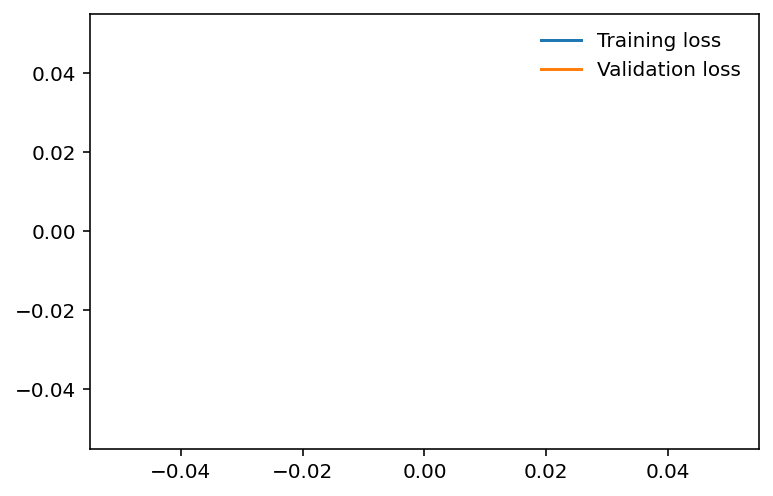

In [6]:
'''plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()'''